# Introduction to NetworkX in Python

Networks enable questions about connectivity, for example: shortest path, centrality, sources and sinks, and rate of flow (Kuhn, 2012). By referencing these core concepts in the spatializations that we implement, we are able to extend the powerful idea of spatial search to spatialized themes and enable scholars to explore the relatedness of research.

In order to enable the discovery of related research, we implemented several spatializations of research themes. The steps we took to do so are summarized as follows:
- Harvest the metadata of research theses
- Assign themes to documents using topic modeling on metadata
- Spatialize themes using existing spatialization algorithms
- Implement a network view

These are the packages we will use to construct the network:

In [37]:
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import networkx as nx

Our first example of a graph will be an empty graph. To see the proper mathematical definition of a graph, you can have a look at our previous chapter Graphs in Python. The following little Python script uses NetworkX to create an empty graph:

In [3]:
G=nx.Graph()

print(G.nodes())
print(G.edges())

print(type(G.nodes()))
print(type(G.edges()))

[]
[]
<class 'networkx.classes.reportviews.NodeView'>
<class 'networkx.classes.reportviews.EdgeView'>


## Adding Nodes to the graph

Now we will add some nodes to our graph. We can add one node with the method add_node() and a list of nodes with the method add_nodes_from():

In [4]:
# adding just one node:
G.add_node("a")
# a list of nodes:
G.add_nodes_from(["b","c"])

print("Nodes of graph: ")
print(G.nodes())
print("Edges of graph: ")
print(G.edges())

Nodes of graph: 
['a', 'b', 'c']
Edges of graph: 
[]


## Adding Edges to the graph

G can also be created or increased by adding one edge at a time by the method add_edge(), which has the two nodes of the edge as the two parameters. If we have a tuple or a list as the edge, we can use the asterisk operator to unpack the tuple or the list:

In [5]:
G.add_edge(1,2)
edge = ("d", "e")
G.add_edge(*edge)
edge = ("a", "b")
G.add_edge(*edge)

print("Nodes of graph: ")
print(G.nodes())
print("Edges of graph: ")
print(G.edges())

Nodes of graph: 
['a', 'b', 'c', 1, 2, 'd', 'e']
Edges of graph: 
[('a', 'b'), (1, 2), ('d', 'e')]


We can add a bunch of edges as a list of edges in the form of 2 tuples.

In [6]:
# adding a list of edges:
G.add_edges_from([("a","c"),("c","d"), ("a",1), (1,"d"), ("a",2)])

We can also print the resulting graph by using matplotlib:

/Users/admin/anaconda3/envs/pystan_2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning:

isinstance(..., numbers.Number)



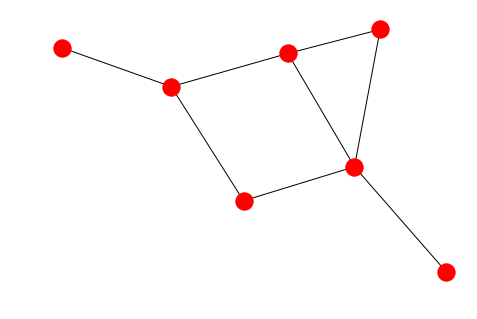

In [7]:
nx.draw(G)
plt.savefig("simple_path.png") # save as png
plt.show() # display

## Using data from UCSB student thesis metadata

We focus on resources accessible through the Alexandria Digital Research Library (ADRL), which is curated by the UC Santa Barbara Library. We first created a list of nodes and edges from the metadata. A node list is a set of objects that consists of a list of all the individual dissertations (nodes) and their attributes, including:
- Title
- Year
- Author
- Degree Grantor
- Supervisor
- Department

An edge list is a set of objects that consists of all possible pairings between nodes. Our edge list contains additional columns that describe the attributes of an edge, such as the strength of topical correspondence.

We will make use of some data description packages first.

In [677]:
import numpy as np

pd.options.display.max_rows = 10

For example, let's start by reading in data sampled from ADRL (adapted from https://alexandria.ucsb.edu/collections/f3348hkz). This dataset was created by identifying all possible identifier topic pairings from the 1,731 dissertatiosn in original ADRL data (only retaining one match in each direction as we do not want repeat matchings). From this, only retain pairs with different identifiers but the same topic. This procedure leaves duplicates where identifiers have multiple top three topics in common. The same details (e.g. Author1) have been kept for the linked dissertations brought into the network through the shared topic relationship. 
To inspect the data:

In [678]:
df_top_3 = pd.read_csv('DF_TOP_5.csv', delimiter = ',', low_memory=False,  encoding='latin-1')
df_top_3.head()

Unnamed: 0 identifier topic_num    weight Department identifier1  \
0         392   f3000017   topic25  0.017359  Sociology    f300002p   
1        1909   f3000017    topic7  0.071949  Sociology    f300002p   
2        1910   f3000017    topic7  0.071949  Sociology    f3000034   
3        5275   f300002p    topic7  0.010096  Chemistry    f3000034   
4         393   f3000017   topic25  0.017359  Sociology    f300006g   

  topic_num1   weight1                                 Department1  source  \
0    topic25  0.005365                                   Chemistry       1   
1     topic7  0.010096                                   Chemistry       1   
2     topic7  0.382661  Counseling, Clinical and School Psychology       1   
3     topic7  0.382661  Counseling, Clinical and School Psychology       2   
4    topic25  0.026381                                   Education       1   

   target  
0       2  
1       2  
2       3  
3       3  
4       4

Edges are constructed between nodes which share a strong topical coherence. Strength is defined by any sampled node that shares a top three topic with another node in the ADRL dataset. The rationale behind choosing the top three topics (out of 71) is that, on average, selecting the top three topics explains 74% of all topical coherence (L). Although increasing the amount of top topics increases the overall topical coherence, for the purposes of this research, we believe selecting top three topics strikes a balance between the network’s ability to adequately explain content of the publications, and network parsimony. 

In [679]:
df1_top_3 = df_top_3.groupby('identifier')
df2_top_3 = df1_top_3.apply(lambda x: x.sample(n=5, replace=True))
df2_top_3.to_csv('df2_top_3.csv', sep=',')

To start, we randomly sample without replacement 775 nodes from the total 1,731. By sampling 775, we reduce complexity within the network, yet still retain topical and departmental diversity. This table gives details of the Title, Year, Author, Degree Grantor, Supervisor and Department for each 50 sampled dissertations. 

In [680]:
df3_top_3 = df2_top_3[0:775]
df3_top_3.head()

Unnamed: 0 identifier topic_num    weight Department  \
identifier                                                                
f3000017   192238          46   f3000017    topic1  0.054469  Sociology   
           895392        3299   f3000017    topic7  0.071949  Sociology   
           1436          1939   f3000017    topic7  0.071949  Sociology   
           28168         2042   f3000017    topic7  0.071949  Sociology   
           462577        1128   f3000017   topic25  0.017359  Sociology   

                  identifier1 topic_num1   weight1  \
identifier                                           
f3000017   192238    f3707znq     topic1  0.108569   
           895392    f3v122ss     topic7  0.078065   
           1436      f30g3h90     topic7  0.099532   
           28168     f32f7kjr     topic7  0.004141   
           462577    f3ft8j8b    topic25  0.001730   

                                             Department1  source  target  
identifier                                                                
f3000017   192238                                History       1     422  
           895392  Education, Joint Program Cal Poly SLO       1    1497  
           1436                                Education       1      33  
           28168                             Mathematics       1     148  
           462577                              Materials       1     837

In [681]:
df3_top_3.to_csv('df3_top_3.csv', sep=',')

Now we read in the nodelist to attach a colour to each department. 

In [682]:
lookup = pd.read_csv('ADRL_UTF.csv', delimiter = ',', error_bad_lines=False)

Department_lookup = dict(zip(lookup, range(len(lookup))))
key = lookup.key
Department = lookup.department

b'Skipping line 10: expected 10 fields, saw 19\nSkipping line 15: expected 10 fields, saw 19\nSkipping line 29: expected 10 fields, saw 19\nSkipping line 65: expected 10 fields, saw 19\nSkipping line 68: expected 10 fields, saw 19\nSkipping line 72: expected 10 fields, saw 19\nSkipping line 86: expected 10 fields, saw 19\nSkipping line 88: expected 10 fields, saw 19\nSkipping line 91: expected 10 fields, saw 19\nSkipping line 95: expected 10 fields, saw 19\nSkipping line 99: expected 10 fields, saw 19\nSkipping line 105: expected 10 fields, saw 19\nSkipping line 123: expected 10 fields, saw 19\nSkipping line 128: expected 10 fields, saw 27\nSkipping line 138: expected 10 fields, saw 19\nSkipping line 143: expected 10 fields, saw 19\nSkipping line 155: expected 10 fields, saw 19\nSkipping line 156: expected 10 fields, saw 19\nSkipping line 164: expected 10 fields, saw 19\nSkipping line 170: expected 10 fields, saw 19\nSkipping line 173: expected 10 fields, saw 19\nSkipping line 193: exp

In [683]:
lookup.head()

Unnamed: 0  key identifier  \
0           1    0   f3bz65v3   
1           2    1   f3tx3f6r   
2           3    2   f3ws8t2n   
3           4    3   f3s182bm   
4           5    4   f38052dc   

                                               title  year  \
0  Complex short-time and small-scale behavior of...  2016   
1  The Effect of Sociocultural Linguistics Pedago...  2016   
2  Wings Well Braced with Bone : Ibsen, Gender, a...  2016   
3  Consciousness and Resistance in Chicano Barrio...  2016   
4  Cosmogenic 35S as an Intrinsic Hydrologic Trac...  2016   

                     author  \
0            Mayer, Hans C.   
1                 Bax, Anna   
2              Jensen, Anna   
3         Nez, Ana Arellano   
4  Uriostegui, Stephanie H.   

                                      degree_grantor              department  \
0  University of California, Santa Barbara. Mecha...  Mechanical Engineering   
1  University of California, Santa Barbara. Lingu...             Linguistics   
2  University of California, Santa Barbara. Theat...         Theater Studies   
3  University of California, Santa Barbara. Compa...  Comparative Literature   
4  University of California, Santa Barbara. Geolo...     Geological Sciences   

      degree_supervisor                                        description  
0  Rouslan Krechetnikov  In this work, several case studies involving c...  
1         Mary Bucholtz  In this thesis, I explore the question of whet...  
2        Simon Williams  Scholarship on Henrik Ibsen has long noted his...  
3   Francisco A. Lomeli  Chicano barrios in the U.S. are commonly repre...  
4          Jordan Clark  The current drought crisis in California highl...

Building a data frame with characteristics for your nodes and creating a dictionary helps the graph look up the unique RGBA values for each department.

In [684]:
carac_top_3 = pd.DataFrame({'key': key,
                      'Department': Department
        })
carac_top_3.drop_duplicates(subset=None, keep='first', inplace=False)
carac_top_3.dropna()
carac_top_3.head()

key              Department
0    0  Mechanical Engineering
1    1             Linguistics
2    2         Theater Studies
3    3  Comparative Literature
4    4     Geological Sciences

Now we can build the basic graph structure.

In [685]:
g = nx.from_pandas_edgelist(df3_top_3, source='source', target='target')

Reorder carac to assign the good color to each node.

In [686]:
carac_top_3= carac_top_3.set_index('key')
carac_top_3=carac_top_3.reindex(g.nodes())
carac_top_3.head()

Department
key                       
1              Linguistics
422          Communication
1497               English
33           Communication
148   Chemical Engineering

In [687]:
carac_top_3['Department']=pd.Categorical(carac_top_3['Department'])
carac_top_3['Department'].cat.codes

key
1       41
422     12
1497    27
33      12
148      6
        ..
856     60
580     43
1433    22
155     58
1353    45
Length: 731, dtype: int8

And transform the categorical column in a numerical value: Department0->0, Department1->1.

In [690]:
carac_top_3.to_csv('carac_top_3.csv', sep=',')

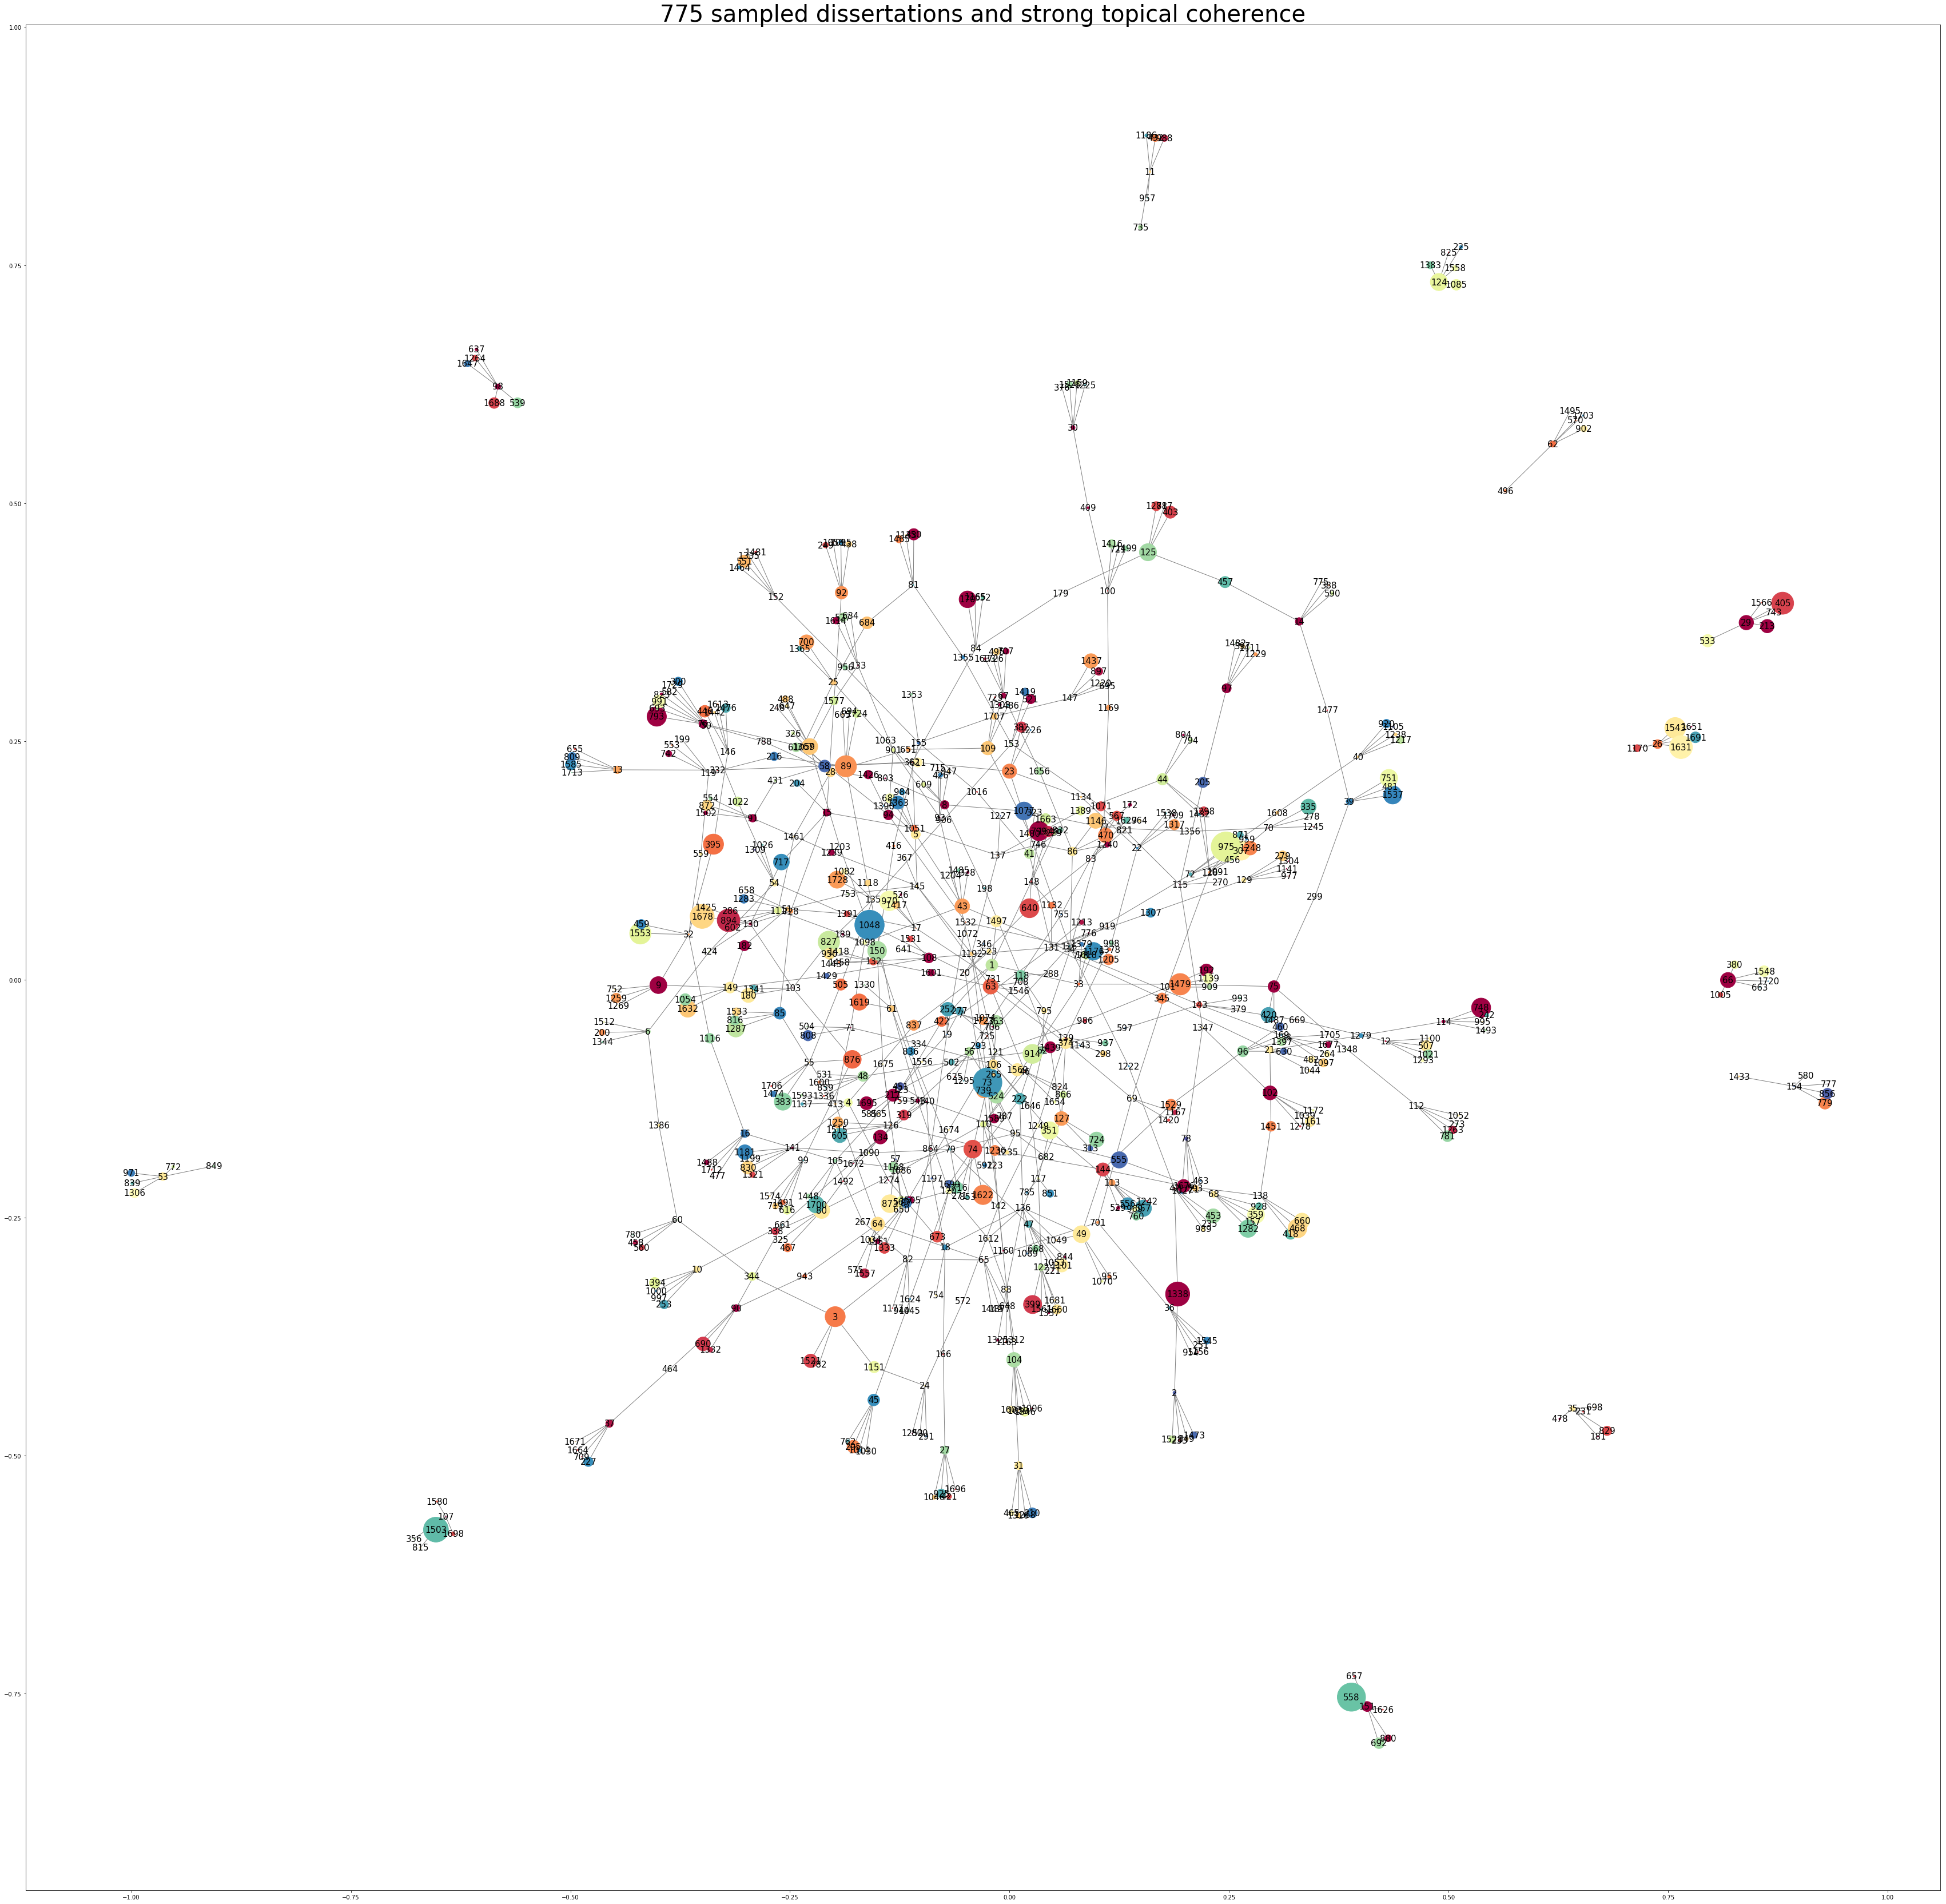

In [691]:
import matplotlib.patches as mpatches
cmap = plt.cm.Spectral


nx.draw_networkx(g, node_size = df3_top_3['weight1'].values * 4000, edge_color = 'grey', cmap = cmap, node_color = carac_top_3['Department'].cat.codes, font_size = 15, width = 1)
plt.title("775 sampled dissertations and strong topical coherence", fontsize = 40)
plt.gcf().set_size_inches(60, 60)
plt.savefig("ADRL_node_col_order.png", format="PNG")
plt.show()

In [692]:
cmap = plt.cm.Spectral

val_map = {'Anthropology': 0,
           'Applied Maths': 1,
           'Art History': 2,
           'Biomolecular Science and Engineering': 3,
           'Chemical Engineering': 4, 
           'Chemistry:': 5, 
           'Chemistry and Biochemistry': 6, 
           'Chicana and Chicano Studies':7,
           'Classics': 8, 
           'Communication': 9, 
           'Comparative Literature': 10, 
           'Computer Science': 11,
           'Computer Science - Engineering': 12,
           'Counseling, Clinical and School Psychology': 13,
           'Department': 14,
           'Department of Economics': 15,
           'Dramatic Art': 16,
           'Earth Science': 17,
           'East Asian Languages and Cultural Studies': 18,
           'East Asian Languages and Cultures': 19,
           'Ecology, Evolution and Marine Biology': 20,
           'Ecology, Evolution, and Marine Biology': 21,
           'Economics': 22,
           'Education': 23,
           'Education - Gevirtz Graduate School': 24,
           'Education, Joint Program Cal Poly SLO': 24,
           'Electrical and Computer Engineering': 25,
           'English': 26,
           'Environmental Science and Management': 27,
           'Feminist Studies': 28,
           'Film and Media Studies': 29,
           'French': 30,
           'French and Italian': 31,
           'Geography': 32,
           'Geography, Joint Program SDSU': 33,
           'Geological Sciences': 34, 
           'Global and International Studies': 35,
           'Global Studies': 36,
           'History': 37,
           'Latin American and Iberian Studies': 38,
           'Linguistics': 39,
           'Marine Science': 40,
           'Materials': 41,
           'Mathematics': 42,
           'Mechanical Engineering': 43,
           'Media Arts and Technology': 44,
           'Molecular, Cellular, and Developmental Biology': 45, 
           'Music': 46, 
           'California Polytechnic State University. Education, Joint Program Cal Poly SLO': 47, 
           'San Diego State University. Geography': 48,
           'Philosophy': 49,
           'Physics': 50,
           'Political Science': 51,
           'Psychological and Brain Sciences': 52,
           'Psychology': 53,
           'Religious Studies': 54,
           'Sociology': 55, 
           'Spanish': 56, 
           'Spanish and Portuguese': 57,
           'Statistics and Applied Probability': 58,
           'Theater and Dance': 59,
           'Theater Studies': 60
          }

In [693]:
import matplotlib.colors
import matplotlib.cm as cmx

In [694]:
cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=max(values))

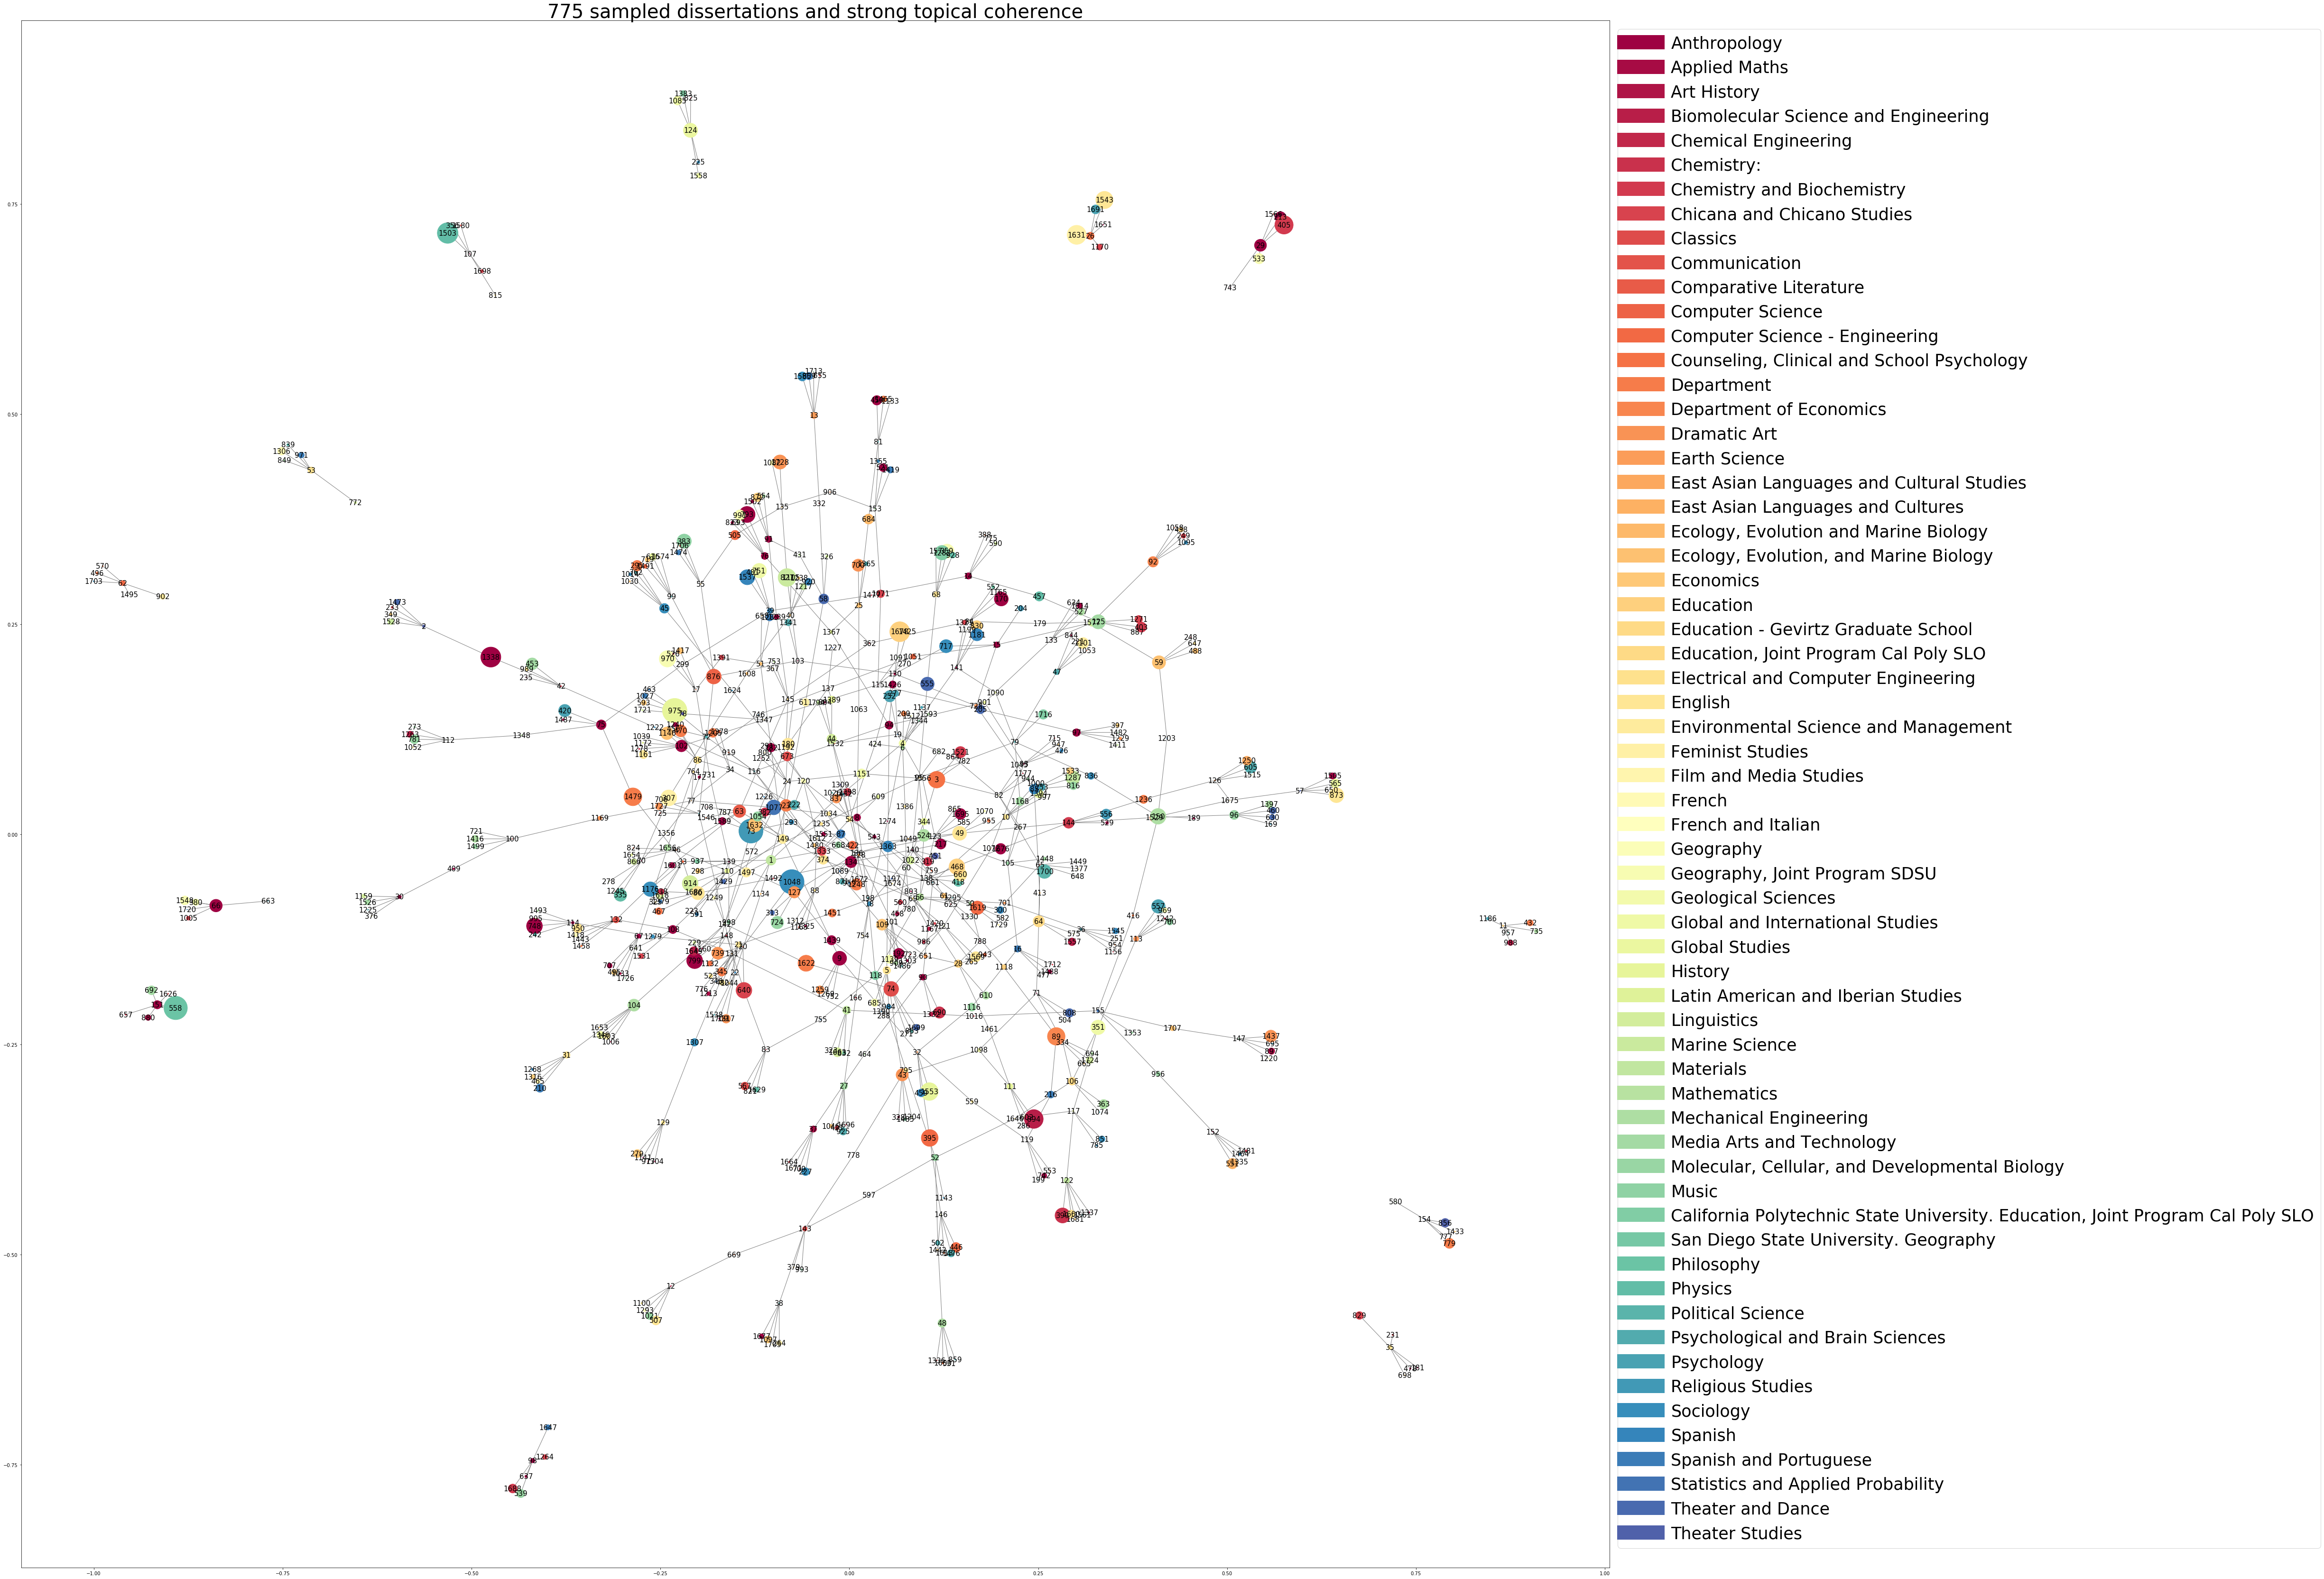

In [695]:
G = nx.from_pandas_edgelist(df3_top_3, source='source', target='target')
cmap = plt.cm.Spectral

values = carac_top_3['Department'].cat.codes

cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=max(values))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)

# Using a figure to use it as a parameter when calling nx.draw_networkx
f = plt.figure(1)
ax = f.add_subplot(1,1,1)

for label in val_map:
    ax.plot([0],[0],
            color=scalarMap.to_rgba(val_map[label]),
            label=label,
            lw = 30)

nx.draw_networkx(G, 
                 cmap = cmap, 
                 node_size = df3_top_3['weight1'].values * 4000, 
                 edge_color = 'grey', 
                 node_color = values, 
                 font_size = 15, 
                 width = 1, 
                 vmin=0, 
                 vmax= max(values),
                 with_labels=True,
                 ax=ax)

plt.title("775 sampled dissertations and strong topical coherence", fontsize = 40)
plt.gcf().set_size_inches(60, 60)
plt.savefig("ADRL.png", format="PNG")
plt.legend(loc='upper left', prop={'size': 35},bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

The graph shows the 775 sampled nodes from the ADRL data. These nodes are embedded and located using their topic weight. This centralises nodes that have a low topic weighting, and the further out the node is embedded, the strong the topical coherence and the more the node is an outlier (in terms of it focussing on a niche topic). 

# Comparing the SOM and the Network
To enable a comparison between the SOM and the Network, the following steps are completed:
- Selecting 775 dissertations from 10 departments 
- pair the dissertations based on top 3 shared topics

To prepare the dataset we drop duplicate pairs:

In [761]:
df2_top_3.drop_duplicates(subset=None, keep='first', inplace=False)

Unnamed: 0 identifier topic_num    weight Department  \
identifier                                                                 
f3000017   192238           46   f3000017    topic1  0.054469  Sociology   
           895392         3299   f3000017    topic7  0.071949  Sociology   
           1436           1939   f3000017    topic7  0.071949  Sociology   
           28168          2042   f3000017    topic7  0.071949  Sociology   
           462577         1128   f3000017   topic25  0.017359  Sociology   
...                        ...        ...       ...       ...        ...   
f3474825   284391      1048473   f3474825   topic25  0.152447  Chemistry   
           1022560     1048179   f3474825   topic19  0.033475  Chemistry   
           1024806     1048182   f3474825   topic19  0.033475  Chemistry   
           425890      1047544   f3474825   topic19  0.033475  Chemistry   
           264222      1047375   f3474825   topic19  0.033475  Chemistry   

                   identifier1 topic_num1   weight1  \
identifier                                            
f3000017   192238     f3707znq     topic1  0.108569   
           895392     f3v122ss     topic7  0.078065   
           1436       f30g3h90     topic7  0.099532   
           28168      f32f7kjr     topic7  0.004141   
           462577     f3ft8j8b    topic25  0.001730   
...                        ...        ...       ...   
f3474825   284391     f39c6vbg    topic25  0.004098   
           1022560    f3z899c9    topic19  0.000382   
           1024806    f3z899jj    topic19  0.175609   
           425890     f3dz069p    topic19  0.000361   
           264222     f38w3bfb    topic19  0.000679   

                                              Department1  source  target  
identifier                                                                 
f3000017   192238                                 History       1     422  
           895392   Education, Joint Program Cal Poly SLO       1    1497  
           1436                                 Education       1      33  
           28168                              Mathematics       1     148  
           462577                               Materials       1     837  
...                                                   ...     ...     ...  
f3474825   284391                               Economics     257     563  
           1022560                              Chemistry     257    1688  
           1024806                                History     257    1691  
           425890                               Materials     257     780  
           264222                  Spanish and Portuguese     257     532  

[1285 rows x 11 columns]

Dropping N/A:

In [762]:
df2_top_3.dropna()

Unnamed: 0 identifier topic_num    weight Department  \
identifier                                                                 
f3000017   192238           46   f3000017    topic1  0.054469  Sociology   
           895392         3299   f3000017    topic7  0.071949  Sociology   
           1436           1939   f3000017    topic7  0.071949  Sociology   
           28168          2042   f3000017    topic7  0.071949  Sociology   
           462577         1128   f3000017   topic25  0.017359  Sociology   
...                        ...        ...       ...       ...        ...   
f3474825   284391      1048473   f3474825   topic25  0.152447  Chemistry   
           1022560     1048179   f3474825   topic19  0.033475  Chemistry   
           1024806     1048182   f3474825   topic19  0.033475  Chemistry   
           425890      1047544   f3474825   topic19  0.033475  Chemistry   
           264222      1047375   f3474825   topic19  0.033475  Chemistry   

                   identifier1 topic_num1   weight1  \
identifier                                            
f3000017   192238     f3707znq     topic1  0.108569   
           895392     f3v122ss     topic7  0.078065   
           1436       f30g3h90     topic7  0.099532   
           28168      f32f7kjr     topic7  0.004141   
           462577     f3ft8j8b    topic25  0.001730   
...                        ...        ...       ...   
f3474825   284391     f39c6vbg    topic25  0.004098   
           1022560    f3z899c9    topic19  0.000382   
           1024806    f3z899jj    topic19  0.175609   
           425890     f3dz069p    topic19  0.000361   
           264222     f38w3bfb    topic19  0.000679   

                                              Department1  source  target  
identifier                                                                 
f3000017   192238                                 History       1     422  
           895392   Education, Joint Program Cal Poly SLO       1    1497  
           1436                                 Education       1      33  
           28168                              Mathematics       1     148  
           462577                               Materials       1     837  
...                                                   ...     ...     ...  
f3474825   284391                               Economics     257     563  
           1022560                              Chemistry     257    1688  
           1024806                                History     257    1691  
           425890                               Materials     257     780  
           264222                  Spanish and Portuguese     257     532  

[1285 rows x 11 columns]

 Here we select the Departments to use in the comparison between the SOM and the Network:
- Chemistry
- Computer Science
- Education
- Electrical and Computer Engineering
- Geography
- History
- Materials
- Physics
- Psychology
- Sociology

In [796]:
df2_top_3 = pd.read_csv('df2_top_3.csv', delimiter = ',', low_memory=False,  encoding='latin-1')

In [794]:
df4_top_3 = df2_top_3.loc[df2_top_3['Department'].isin(['Chemistry','Computer Science', 'Education','Electrical and Computer Engineering','Geography','History','Materials','Physics','Psychology','Sociology'])]
df5_top_3 = df4_top_3.loc[df4_top_3['Department1'].isin(['Chemistry','Computer Science', 'Education','Electrical and Computer Engineering','Geography','History','Materials','Physics','Psychology','Sociology'])]
df6_top_3 = df2_top_3.loc[df2_top_3['identifier1'].isin([['f3zw1j1w','f3rf5rzn','f3ms3qvb','f3pg1pw4','f3ws8rfr','f36h4fms','f3wh2mxb','f3jm27tc','f3m61h6q']])]

df6_top_3.head()



Empty DataFrame
Columns: [Unnamed: 0, identifier, topic_num, weight, Department, identifier1, topic_num1, weight1, Department1, source, target]
Index: []

In [799]:
df5_top_3.to_csv('df5_top_3.csv', sep=',')

In [ ]:
lookup_all = pd.read_csv('ADRL_UTF.csv', delimiter = ',', error_bad_lines=False)


Assigning category codes to each of the departments:

### Building a lookup table for the nodes from the 10 departments

In [800]:
df5_top_3 = pd.read_csv('df5_top_3.csv', delimiter = ',', low_memory=False,  encoding='latin-1')

In [801]:
lookup_all = pd.read_csv('ADRL_UTF.csv', delimiter = ',', error_bad_lines=False)
lookup_all.head()

b'Skipping line 10: expected 10 fields, saw 19\nSkipping line 15: expected 10 fields, saw 19\nSkipping line 29: expected 10 fields, saw 19\nSkipping line 65: expected 10 fields, saw 19\nSkipping line 68: expected 10 fields, saw 19\nSkipping line 72: expected 10 fields, saw 19\nSkipping line 86: expected 10 fields, saw 19\nSkipping line 88: expected 10 fields, saw 19\nSkipping line 91: expected 10 fields, saw 19\nSkipping line 95: expected 10 fields, saw 19\nSkipping line 99: expected 10 fields, saw 19\nSkipping line 105: expected 10 fields, saw 19\nSkipping line 123: expected 10 fields, saw 19\nSkipping line 128: expected 10 fields, saw 27\nSkipping line 138: expected 10 fields, saw 19\nSkipping line 143: expected 10 fields, saw 19\nSkipping line 155: expected 10 fields, saw 19\nSkipping line 156: expected 10 fields, saw 19\nSkipping line 164: expected 10 fields, saw 19\nSkipping line 170: expected 10 fields, saw 19\nSkipping line 173: expected 10 fields, saw 19\nSkipping line 193: exp

Unnamed: 0  key identifier  \
0           1    0   f3bz65v3   
1           2    1   f3tx3f6r   
2           3    2   f3ws8t2n   
3           4    3   f3s182bm   
4           5    4   f38052dc   

                                               title  year  \
0  Complex short-time and small-scale behavior of...  2016   
1  The Effect of Sociocultural Linguistics Pedago...  2016   
2  Wings Well Braced with Bone : Ibsen, Gender, a...  2016   
3  Consciousness and Resistance in Chicano Barrio...  2016   
4  Cosmogenic 35S as an Intrinsic Hydrologic Trac...  2016   

                     author  \
0            Mayer, Hans C.   
1                 Bax, Anna   
2              Jensen, Anna   
3         Nez, Ana Arellano   
4  Uriostegui, Stephanie H.   

                                      degree_grantor              department  \
0  University of California, Santa Barbara. Mecha...  Mechanical Engineering   
1  University of California, Santa Barbara. Lingu...             Linguistics   
2  University of California, Santa Barbara. Theat...         Theater Studies   
3  University of California, Santa Barbara. Compa...  Comparative Literature   
4  University of California, Santa Barbara. Geolo...     Geological Sciences   

      degree_supervisor                                        description  
0  Rouslan Krechetnikov  In this work, several case studies involving c...  
1         Mary Bucholtz  In this thesis, I explore the question of whet...  
2        Simon Williams  Scholarship on Henrik Ibsen has long noted his...  
3   Francisco A. Lomeli  Chicano barrios in the U.S. are commonly repre...  
4          Jordan Clark  The current drought crisis in California highl...

In [802]:
lookup_10 = lookup_all.loc[lookup_all['identifier'].isin(df5_top_3['identifier'])]
lookup_10.head()

Unnamed: 0  key identifier  \
17          22   21   f32b8xv8   
41          48   47   f3445m9s   
43          50   49   f3348k5d   
47          54   53   f30k28cn   
49          56   55   f33b5zxr   

                                                title  year  \
17  Ultra-Narrow Bandwidth Optical Resonators for ...  2016   
41  Optical measurement and control of topological...  2016   
43   Group III-V Nanowire Growth and Characterization  2016   
47  Hidden Markov Models for Analysis of Multimoda...  2016   
49  Teachers' and Administrators' Views of Organiz...  2016   

                    author                                     degree_grantor  \
17       Spencer, Daryl T.  University of California, Santa Barbara. Elect...   
41  Yeats, Andrew Loughlin   University of California, Santa Barbara. Physics   
43           Wang, Mingjin  University of California, Santa Barbara. Elect...   
47   Shenoy, Renuka Vidyut  University of California, Santa Barbara. Elect...   
49      Wold, Todd Michael  University of California, Santa Barbara. Educa...   

                             department               degree_supervisor  \
17  Electrical and Computer Engineering                  John E. Bowers   
41                              Physics              David D. Awschalom   
43  Electrical and Computer Engineering                  John E. Bowers   
47  Electrical and Computer Engineering                    Kenneth Rose   
49                            Education  Danielle Harlow, Sharon Conley   

                                          description  
17  The development of narrowband resonators has f...  
41  The spin-polarized surface states of topologic...  
43  Electronic and optical devices typically use b...  
47  Modern advances in imaging technology have ena...  
49  California Partnership Academies (CPAs) are a ...

In [803]:
Department_lookup_10 = dict(zip(lookup_10, range(len(lookup_10))))
key_10 = lookup_10.key
Department_10 = lookup_10.department


In [805]:
Department_lookup_10 = dict(zip(lookup_10, range(len(lookup_10))))

In [806]:
carac_10 = pd.DataFrame({'key': key_10,
        'Department': Department_10
        })
carac_10.head()


key                           Department
17   21  Electrical and Computer Engineering
41   47                              Physics
43   49  Electrical and Computer Engineering
47   53  Electrical and Computer Engineering
49   55                            Education

In [807]:
carac_10.drop_duplicates(subset='Department', keep='first', inplace=True)
carac_10.dropna()
carac_10.head()

key                           Department
17    21  Electrical and Computer Engineering
41    47                              Physics
49    55                            Education
99   123                            Sociology
113  142                              History

In [808]:
val_map_10_dep = {'Chemistry': 1,
                  'Computer Science': 2,
                  'Education': 3,
                  'Electrical and Computer Engineering': 4,
                  'Geography': 5,
                  'History': 6,
                  'Materials': 7,
                  'Physics': 8,
                  'Psychology': 9,
                  'Sociology': 10 
                 }

Using the lookup table to build a dictionary to assign each node a department for the node color:

### Building the graph

In [809]:
f = nx.from_pandas_edgelist(df5_top_3, source='source', target='target')


In [810]:
cmap = plt.cm.Spectral
colors = [n for n in range(len(f.nodes()))]

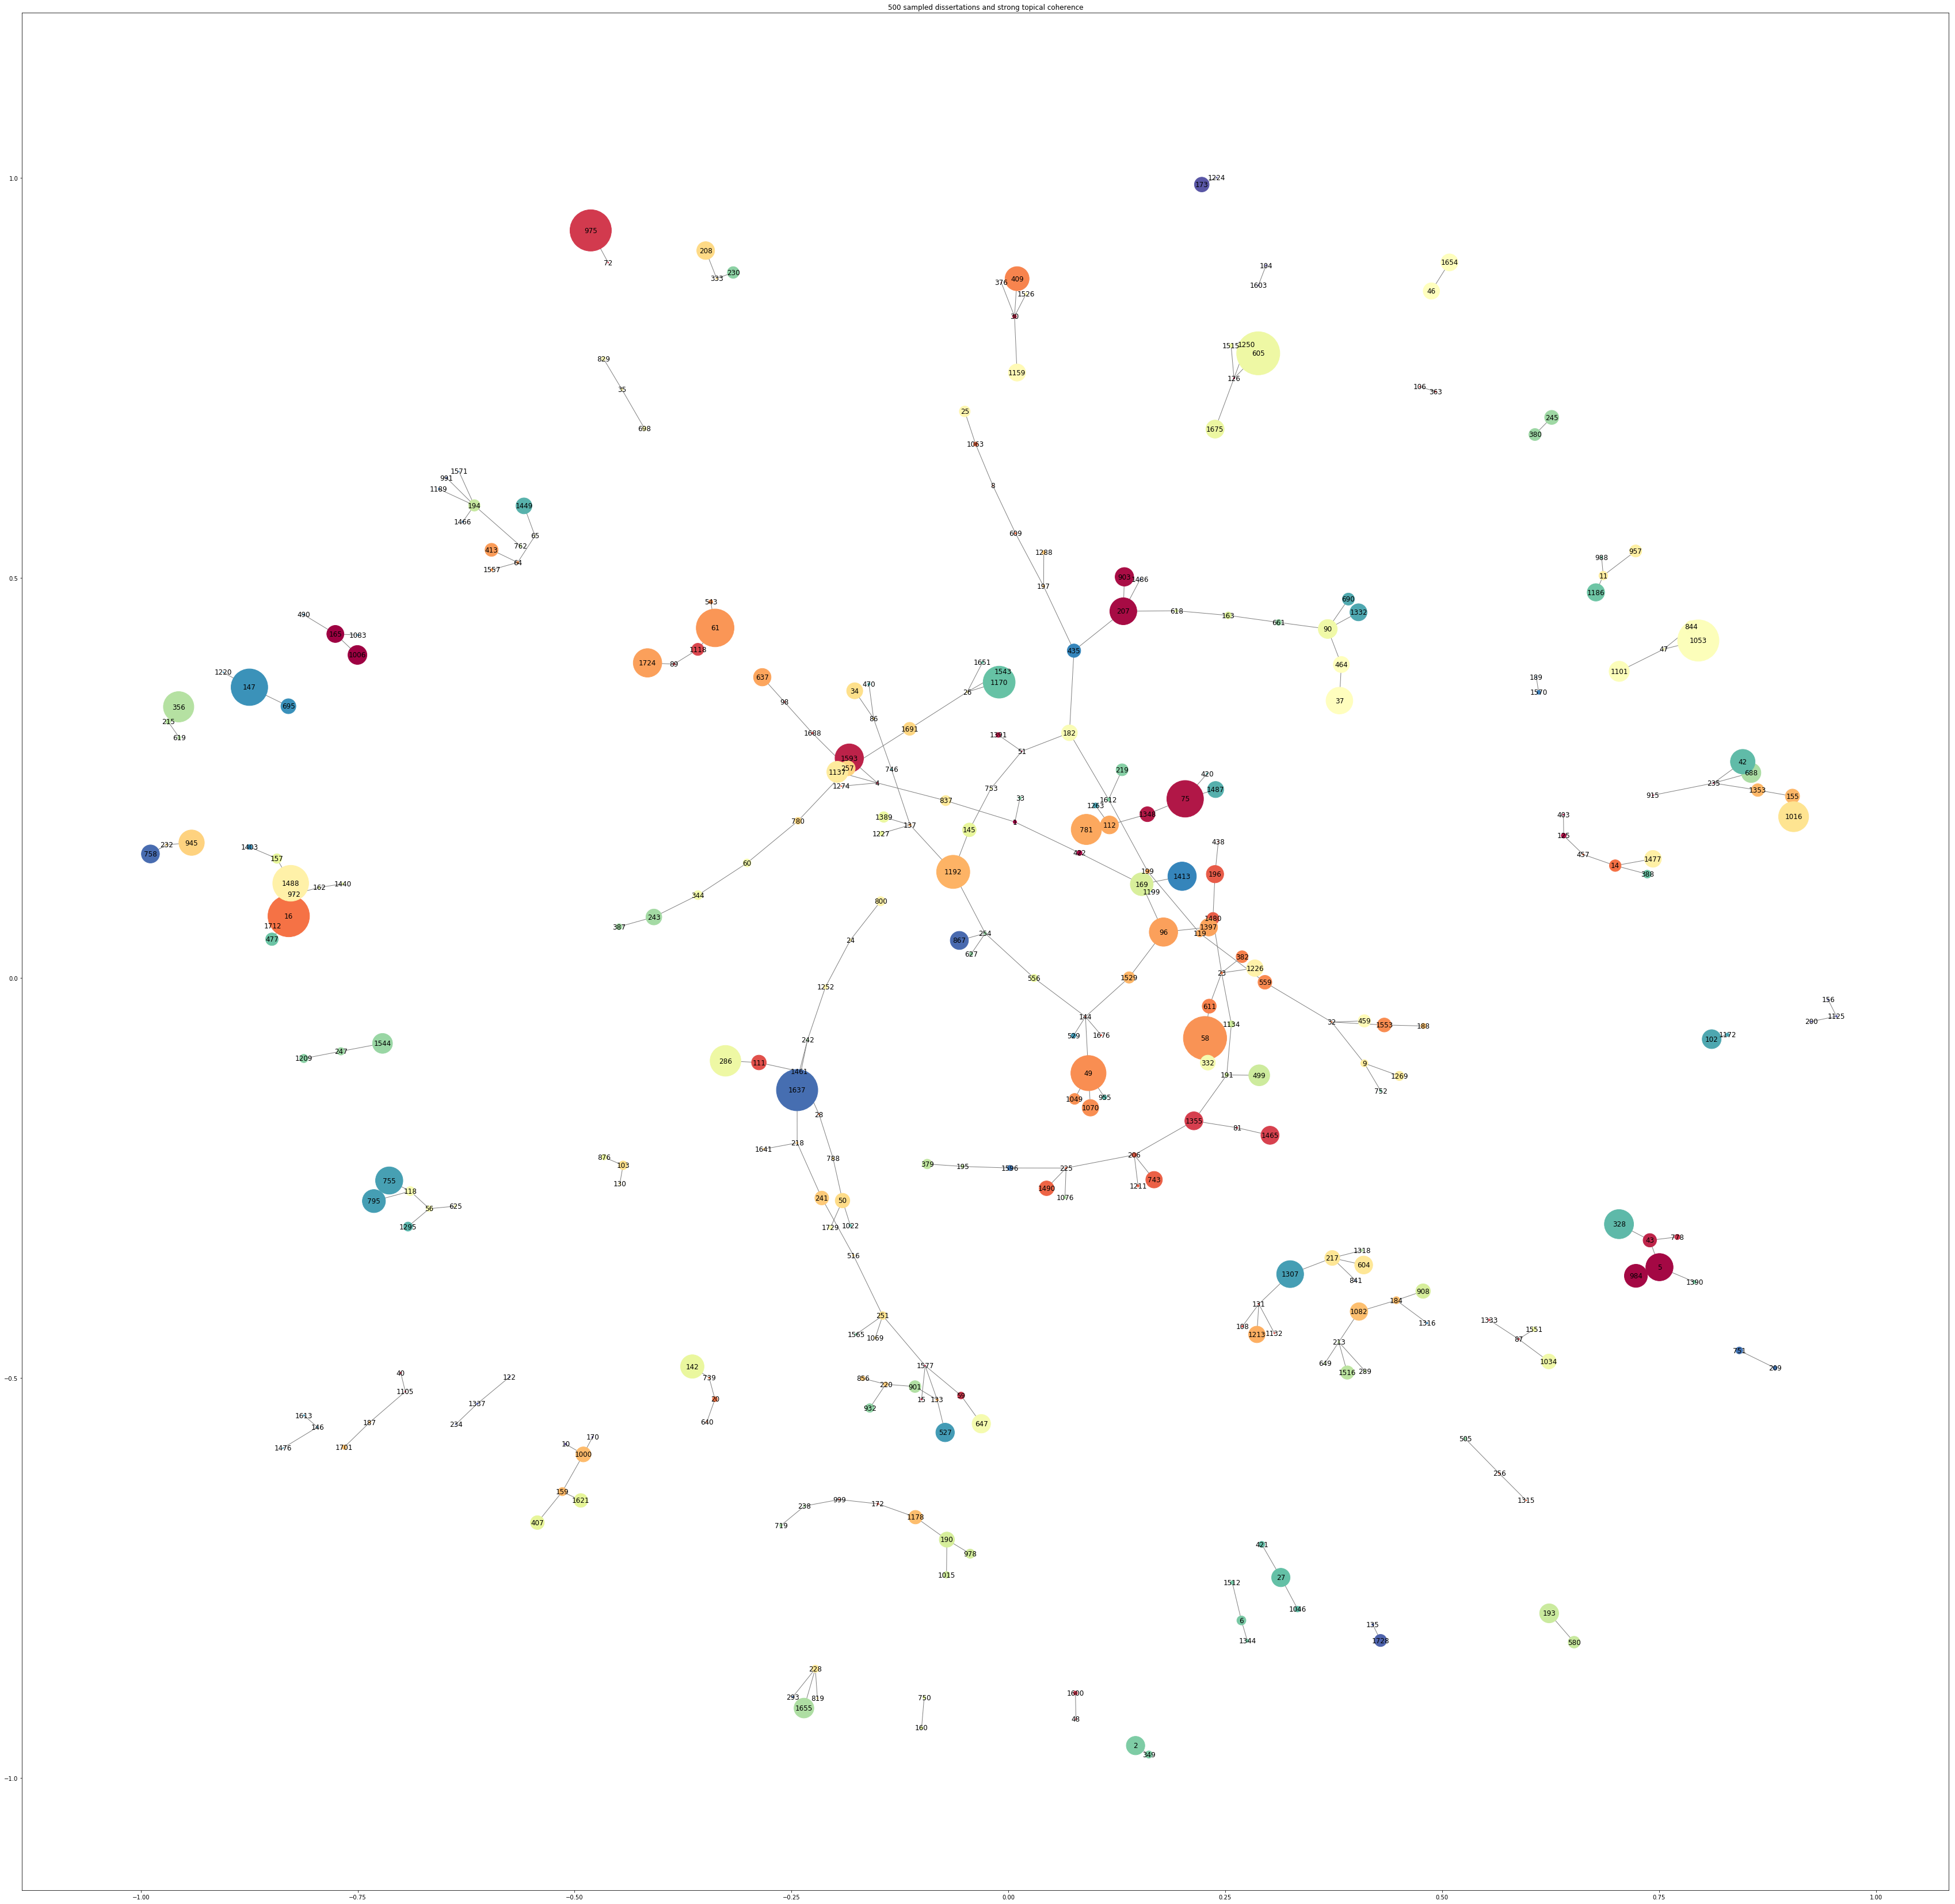

In [811]:
nx.draw_networkx(f, node_size = df5_top_3['weight1'].values * 10000, edge_color = 'grey', cmap = cmap, node_color = colors, width = 1)
plt.title("500 sampled dissertations and strong topical coherence")
plt.gcf().set_size_inches(60, 60)
plt.savefig("ADRL_10_dep_node_color_no_text.png", format="PNG")
plt.show()

# Comparing Networks to Self Organising Maps
Now we will select key nodes to understand the similarities and differences of spatialising tabular data in Self Organising Maps and Networks.

In [779]:
Cluster_lookup = pd.read_csv('ADRL_UTF.csv', delimiter = ',', error_bad_lines=False, index_col = 2)
Cluster_lookup.head()

b'Skipping line 10: expected 10 fields, saw 19\nSkipping line 15: expected 10 fields, saw 19\nSkipping line 29: expected 10 fields, saw 19\nSkipping line 65: expected 10 fields, saw 19\nSkipping line 68: expected 10 fields, saw 19\nSkipping line 72: expected 10 fields, saw 19\nSkipping line 86: expected 10 fields, saw 19\nSkipping line 88: expected 10 fields, saw 19\nSkipping line 91: expected 10 fields, saw 19\nSkipping line 95: expected 10 fields, saw 19\nSkipping line 99: expected 10 fields, saw 19\nSkipping line 105: expected 10 fields, saw 19\nSkipping line 123: expected 10 fields, saw 19\nSkipping line 128: expected 10 fields, saw 27\nSkipping line 138: expected 10 fields, saw 19\nSkipping line 143: expected 10 fields, saw 19\nSkipping line 155: expected 10 fields, saw 19\nSkipping line 156: expected 10 fields, saw 19\nSkipping line 164: expected 10 fields, saw 19\nSkipping line 170: expected 10 fields, saw 19\nSkipping line 173: expected 10 fields, saw 19\nSkipping line 193: exp

Unnamed: 0  key  \
identifier                    
f3bz65v3             1    0   
f3tx3f6r             2    1   
f3ws8t2n             3    2   
f3s182bm             4    3   
f38052dc             5    4   

                                                        title  year  \
identifier                                                            
f3bz65v3    Complex short-time and small-scale behavior of...  2016   
f3tx3f6r    The Effect of Sociocultural Linguistics Pedago...  2016   
f3ws8t2n    Wings Well Braced with Bone : Ibsen, Gender, a...  2016   
f3s182bm    Consciousness and Resistance in Chicano Barrio...  2016   
f38052dc    Cosmogenic 35S as an Intrinsic Hydrologic Trac...  2016   

                              author  \
identifier                             
f3bz65v3              Mayer, Hans C.   
f3tx3f6r                   Bax, Anna   
f3ws8t2n                Jensen, Anna   
f3s182bm           Nez, Ana Arellano   
f38052dc    Uriostegui, Stephanie H.   

                                               degree_grantor  \
identifier                                                      
f3bz65v3    University of California, Santa Barbara. Mecha...   
f3tx3f6r    University of California, Santa Barbara. Lingu...   
f3ws8t2n    University of California, Santa Barbara. Theat...   
f3s182bm    University of California, Santa Barbara. Compa...   
f38052dc    University of California, Santa Barbara. Geolo...   

                        department     degree_supervisor  \
identifier                                                 
f3bz65v3    Mechanical Engineering  Rouslan Krechetnikov   
f3tx3f6r               Linguistics         Mary Bucholtz   
f3ws8t2n           Theater Studies        Simon Williams   
f3s182bm    Comparative Literature   Francisco A. Lomeli   
f38052dc       Geological Sciences          Jordan Clark   

                                                  description  
identifier                                                     
f3bz65v3    In this work, several case studies involving c...  
f3tx3f6r    In this thesis, I explore the question of whet...  
f3ws8t2n    Scholarship on Henrik Ibsen has long noted his...  
f3s182bm    Chicano barrios in the U.S. are commonly repre...  
f38052dc    The current drought crisis in California highl...

We chose to assign dissertations the role of nodes. A node list is a set of objects that consists of a list of all the individual dissertations (nodes). Selecting the following nodes:
- f3zw1j1w' (Psychology)
- 'f3rf5rzn' (Education)
- 'f3ms3qvb' (Psychology)
- 'f3pg1pw4' (Sociology)
- 'f3ws8rfr' (Geography)
- 'f36h4fms' (Music)
- 'f3wh2mxb' (Sociology)
- 'f3jm27tc' (Geography)
- 'f3m61h6q' (Computer Science - Engineering)

enables us to compare the results of the Self-Organising Map and the Network. Code adapted from https://stackoverflow.com/questions/14665767/networkx-specific-nodes-labeling/14667533

### Seelcting nodes corresponding to the selected dissertations
The following nodes are selected from the dataset and illustrate how a network visualisation can aid the search for thematically related documents. 

No handles with labels found to put in legend.


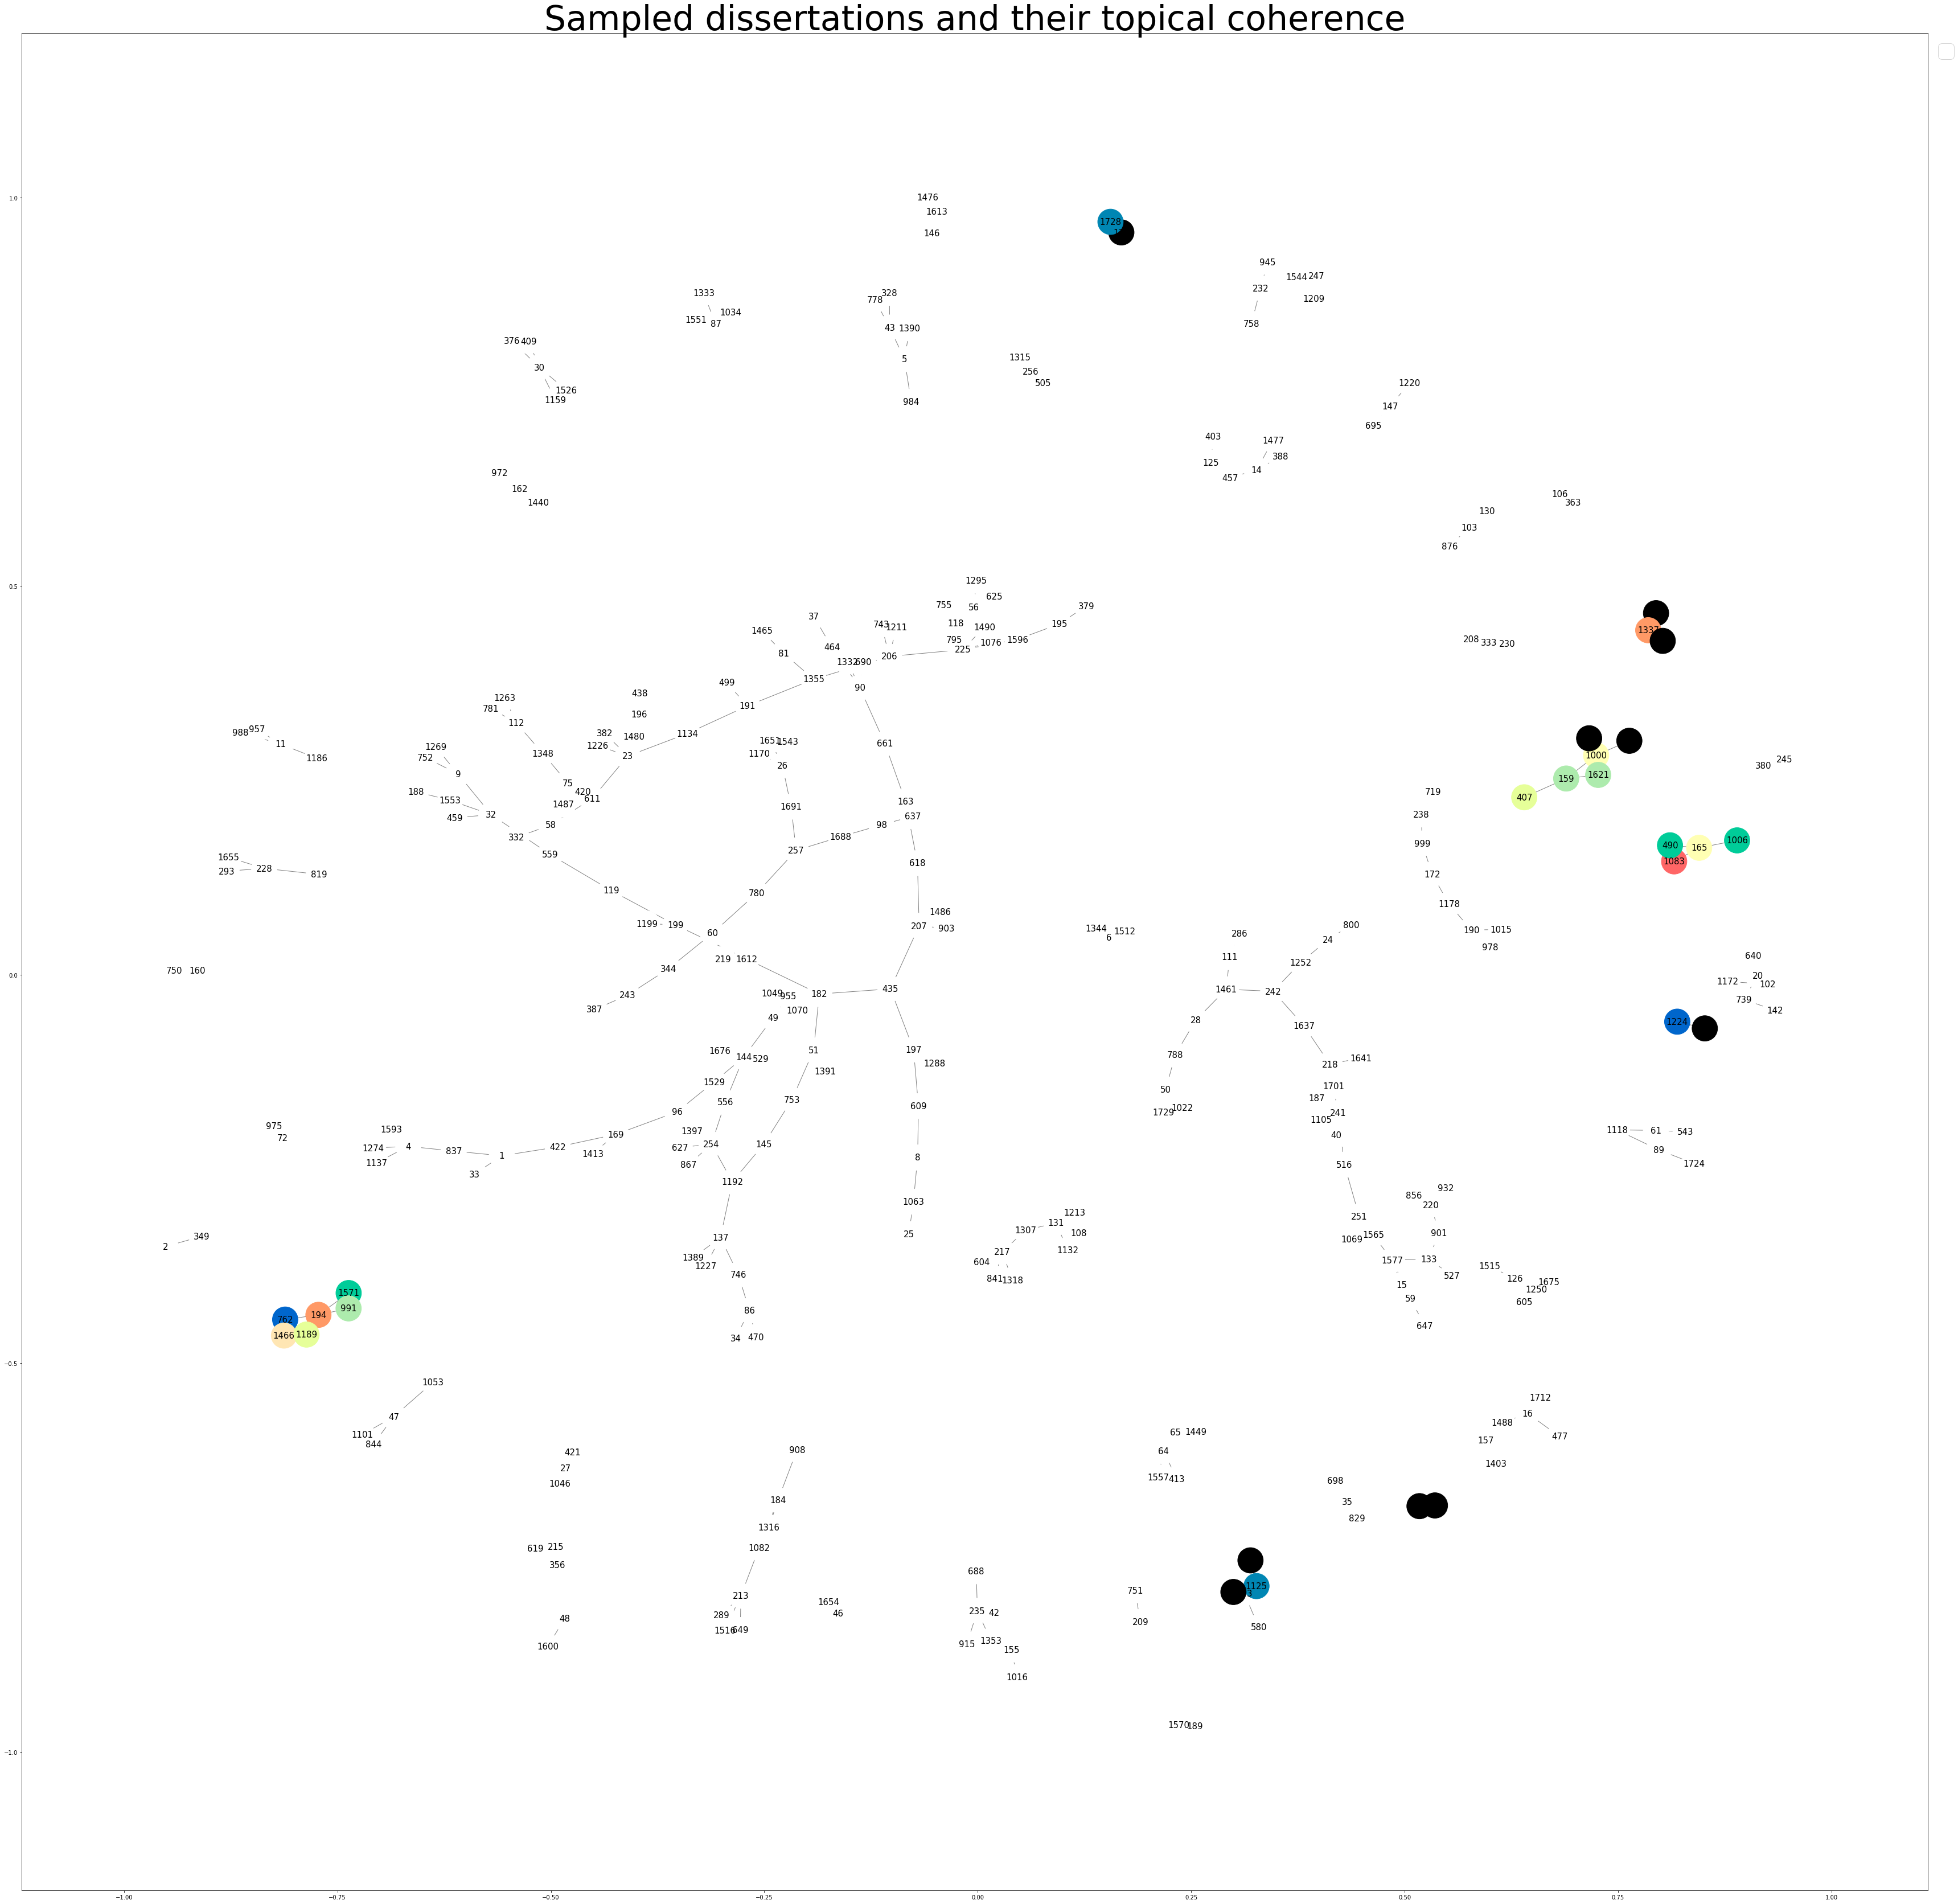

In [862]:
G = nx.from_pandas_edgelist(df5_top_3, source='source', target='target')

color_map = []
for node in G:
    if node == 762:
        color_map.append('#0066cc')
    elif node == 194:
        color_map.append('#ff9966')
    elif node == 1083:
        color_map.append('#ff6666')
    elif node == 165:
        color_map.append('#ffffb3')
    elif node == 1000:
        color_map.append('#ffffb3')
    elif node == 10:
        color_map.append('black')
    elif node == 170:
        color_map.append('black')
    elif node == 159:
        color_map.append('#adebad')
    elif node == 104:
        color_map.append('black')
    elif node == 1603:
        color_map.append('black')
    elif node == 173:
        color_map.append('black')
    elif node == 1224:
        color_map.append('#0066cc')
    elif node == 200:
        color_map.append('black')
    elif node == 1125:
        color_map.append('#0086b3')
    elif node == 156:
        color_map.append('black')
    elif node == 1728:
        color_map.append('#0086b3')
    elif node == 1337:
        color_map.append('#ff9966')
    elif node == 234:
        color_map.append('black')
    elif node == 490:
        color_map.append('#00cc99')
    elif node == 1006:
        color_map.append('#00cc99')
    elif node == 122:
        color_map.append('black')
    elif node == 1311:
        color_map.append('black')
    elif node == 122:
        color_map.append('black')
    elif node == 407:
        color_map.append('#e6ff99')
    elif node == 1621:
        color_map.append('#adebad')
    elif node == 135:
        color_map.append('black')
    elif node == 1466:
        color_map.append('#ffe6b3')
    elif node == 991:
        color_map.append('#adebad')
    elif node == 1571:
        color_map.append('#00cc99')
    elif node == 1189:
        color_map.append('#e6ff99')
    else: color_map.append('white')      
    

f = plt.figure(1)
ax = f.add_subplot(1,1,1)

nx.draw_networkx(G, node_size = 2000,
                 edge_color = 'grey',
                 node_color = color_map, 
                 font_color = 'black',
                 font_size = 15, 
                 width = 1, 
                ax = ax)
plt.title("Sampled dissertations and their topical coherence", fontsize = 60)
plt.gcf().set_size_inches(60, 60)
plt.savefig("ADRL_selected_dissertations.png", format="PNG")
plt.legend(loc='upper left', prop={'size': 35},bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

The circular layout shows which nodes as pulling in all the others. 

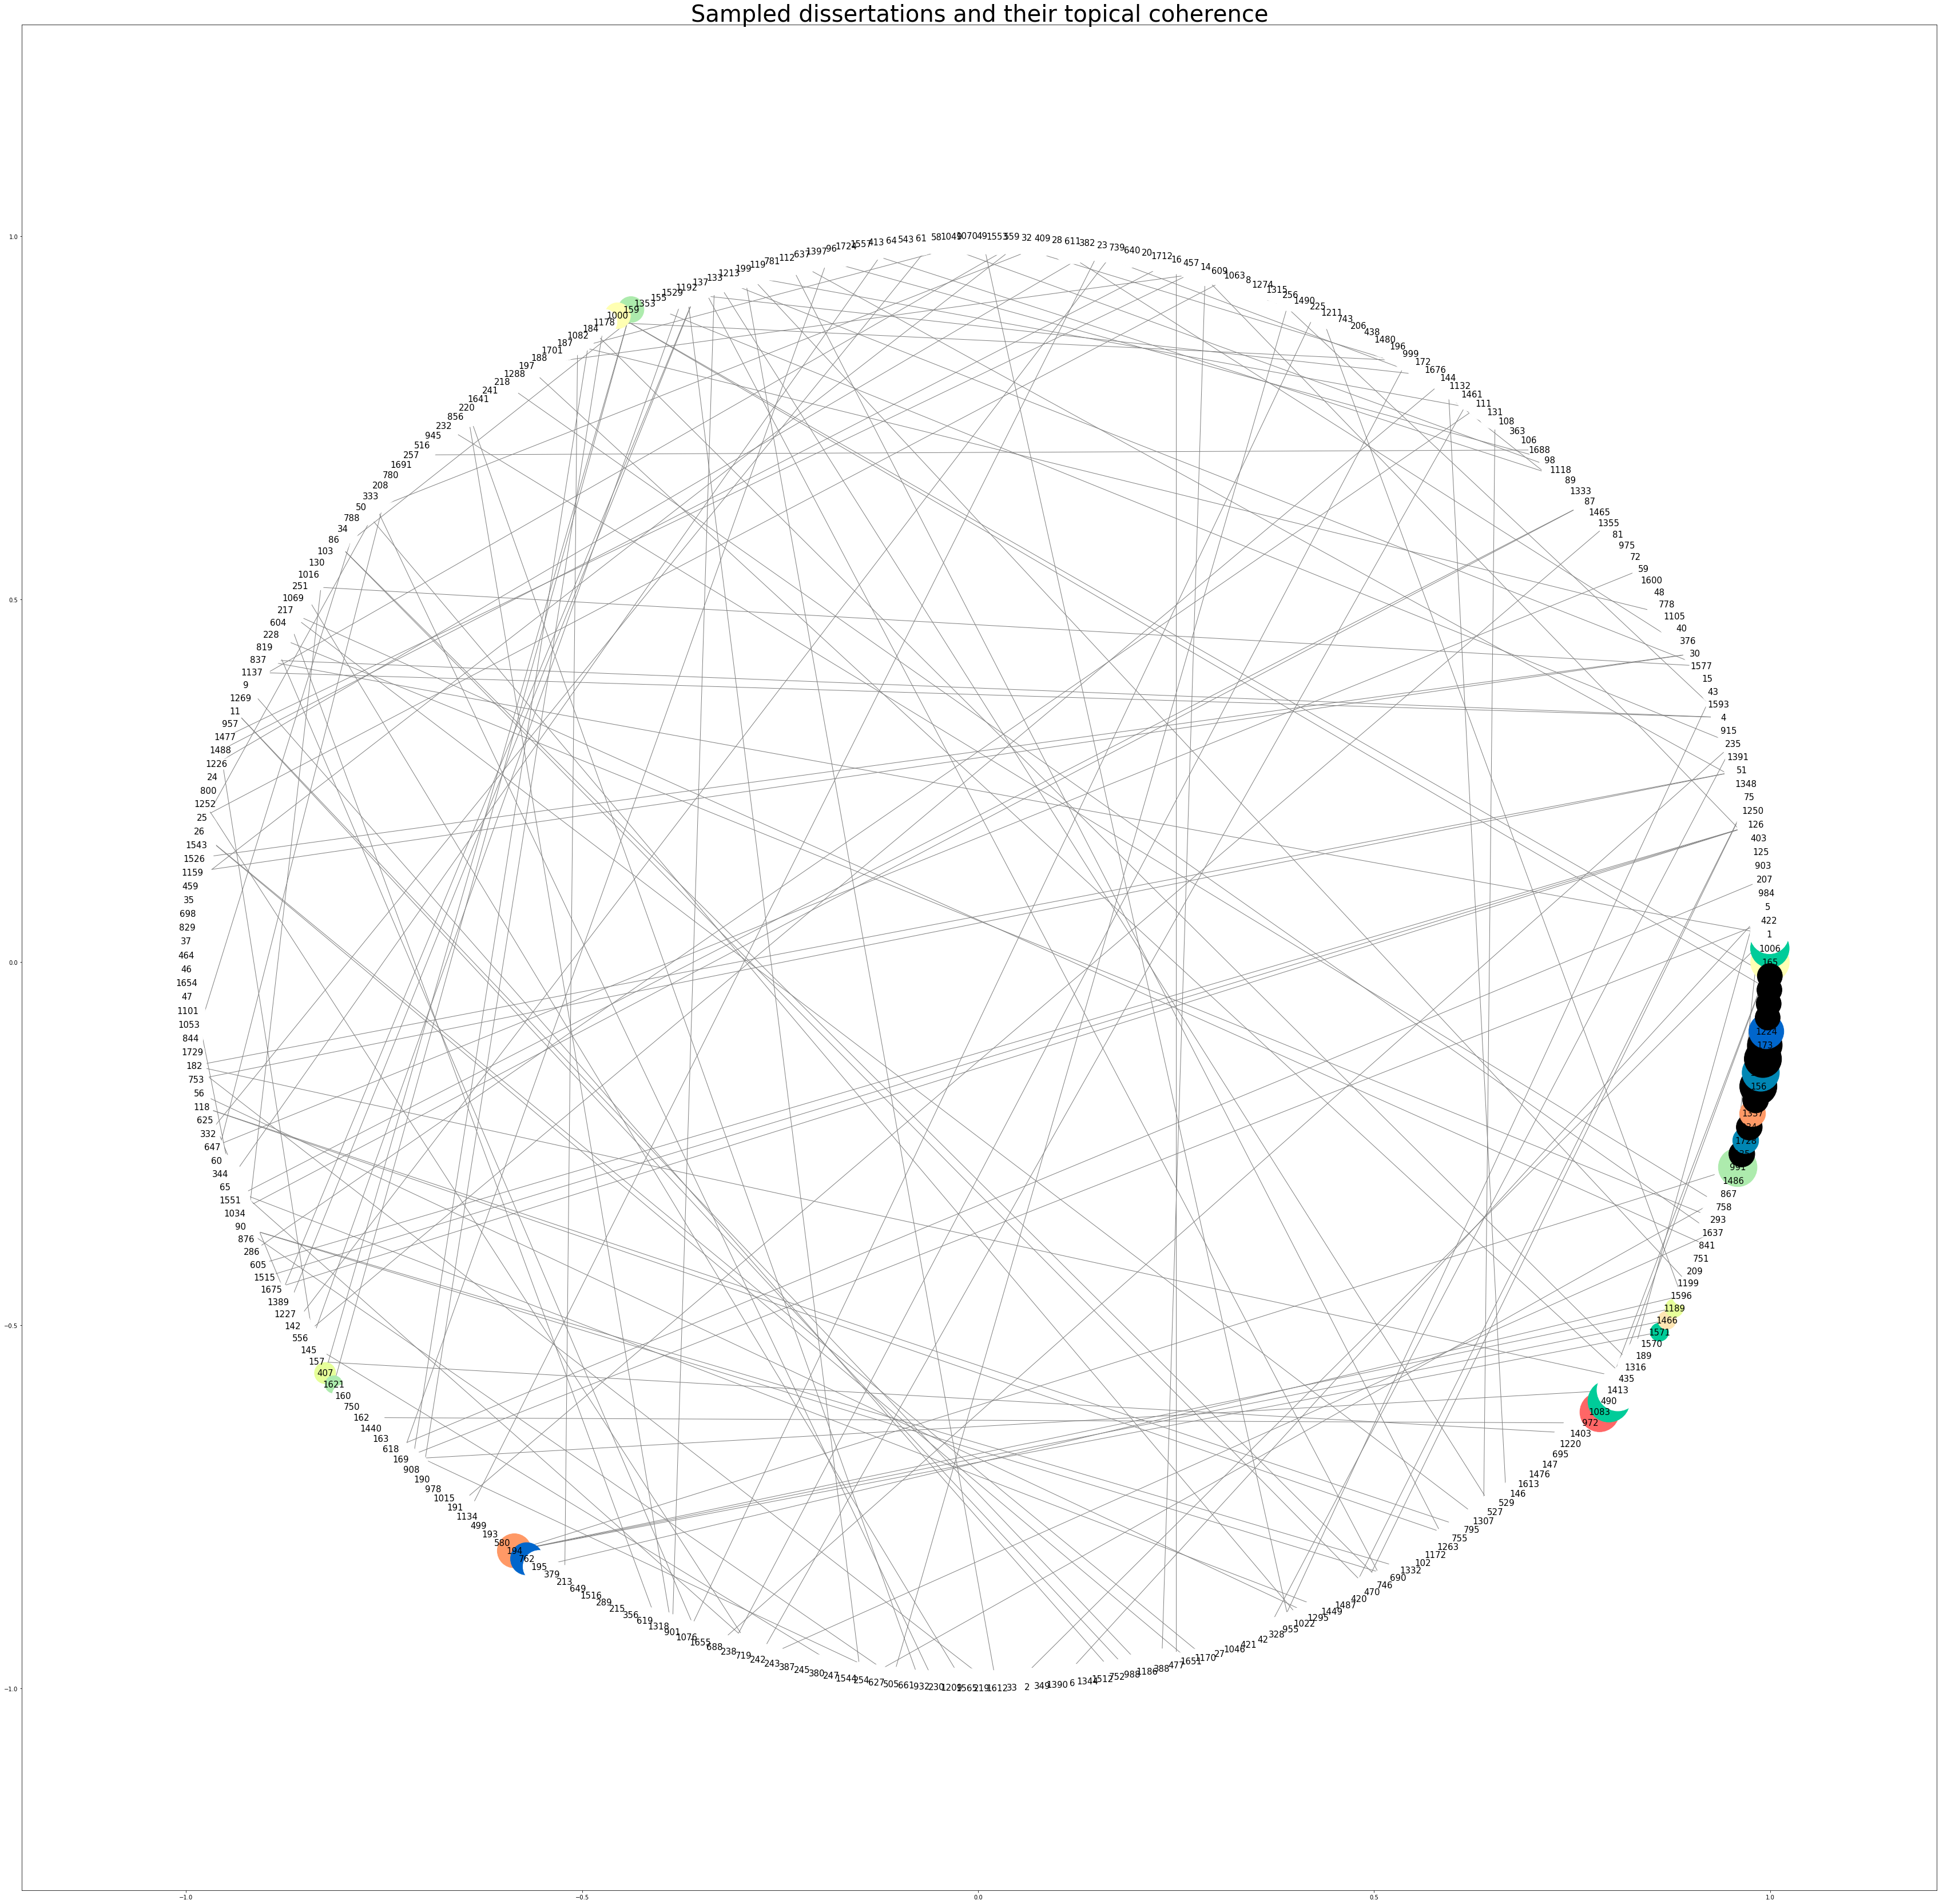

In [863]:
pos = nx.circular_layout(G)
nx.draw_networkx(G, pos, node_size = df4['weight1'].values * 10000, edge_color = 'grey', cmap = cmap, node_color = color_map, font_size = 15, width = 1)
plt.title("Sampled dissertations and their topical coherence", fontsize = 40)
plt.gcf().set_size_inches(60, 60)
plt.show()